## MNIST Classification using PyTorch
Implement a CNN model in PyTorch to classify MNIST dataset, you can use sklearn library to import the mnist dataset.

In [1]:
# This code is based on the pytorch course by Patrick Loeber (https://www.youtube.com/watch?v=c36lUUr864M)

# Importing all required libraries
import torch
import torch.nn as nn
import torchvision # to import the MNIST dataset. Preferred over sklearn because torchvision version is more compatible with pytorch functions
import torchvision.transforms as transforms # to transform arrays to tensors
import matplotlib.pyplot as plt

In [2]:
# Device configuration - to utilise GPU support if available on the test device
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Defining hyper parameters
input_size = 784 # since images are as 28x28 grids
hidden_size = 500 # the size of the inner neural layer
num_classes = 10 # since the input can be classified into one of the digits 0-9
num_epochs = 2 # set low for speed, increase if accuracy isn't good
batch_size = 100 # splitting the dataset into batches for speeding up training
learning_rate = 0.001 # for Stochastic Gradient Descent

In [4]:
# Setting up the data from MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# loading the data, to enable batching ad shuffling of training data (and also enable iterating over batches)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

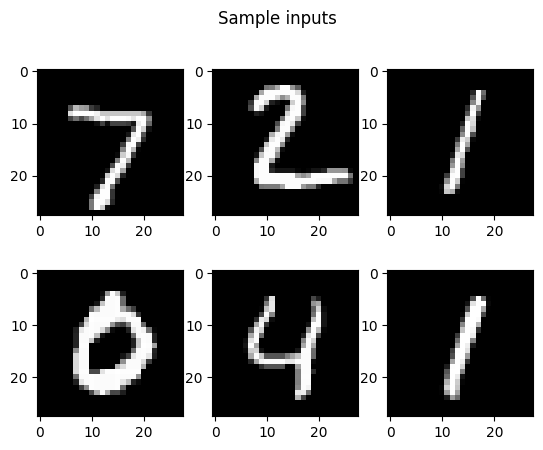

In [5]:
# Printing a sample of the input data
example = iter(test_loader)
example_data, example_targets = next(example)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray') # displaying the images with colormap set to gray
plt.suptitle('Sample inputs')
plt.show()

In [6]:
# Creating a fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # we do not use any activation function here because CrossEntropyLoss, which we use later, takes care of that
        return out
    
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

In [7]:
# Defining loss and optimiser functions
Loss = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr = learning_rate)
# Adam is an optimisation like SGD, but it has additional features like momentum and adaptive learning rate

In [8]:
# Training the model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): # i is index here
        images = images.reshape(-1, 28*28).to(device) # reshaping [100, 1, 28, 28] to [100, 784]
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # loss calculation
        loss = Loss(outputs, labels)
        
        # Backward pass (gradient calculations)
        loss.backward()
        
        # Adjustment of weights
        optimiser.step()
        
        # Resetting grad to zero
        optimiser.zero_grad()

In [9]:
# Testing the model
# We don't compute gradients while doing testing because they are no longer required
with torch.no_grad():
    n_correct = 0
    n_samples = 0 # these two are for calulating accuracy of the model
    total_confidence = 0
    for images, labels in test_loader: # index not required since we are not enumerating
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        output = model(images)
        output = nn.functional.softmax(output, dim=1)
        confidence, predicted = torch.max(output, 1) # The max function returns value, index.
        # and the argument '1' denotes that we want the maximum along each column of output
        
        n_samples += labels.size(0)
        n_correct += (predicted==labels).sum().item() # .item() converts the 0D tensor to an integer
        total_confidence += confidence.sum().item()

In [10]:
# Results
accuracy = n_correct/float(n_samples)
confidence = total_confidence/float(n_samples)
print(f'Accuarcy of the Neural Network on {n_samples} test images = {accuracy*100}%')
print(f'Average confidence of network\'s prediction = {confidence*100: .2f}%')

Accuarcy of the Neural Network on 10000 test images = 97.09%
Average confidence of network's prediction =  96.27%
